<h1 style="line-height: 2;">
From Pixels to Predictions: A Comparative Study of CRF and Auto-context CRF Models Under Varying Sliding Window Contexts
</h1>
by: Michael R. Schaar

### Research Goal
The objective of this study is to explore how contextual information impacts structured character recognition performance by addressing the structured prediction problem using a baseline Conditional Random Field (CRF) model and an Auto-context CRF model across varying sliding window sizes and training/test splits. More specifically, this project aims to measure how much accuracy improves when predictions from an initial CRF are added as features, and how that improvement changes with different amounts of context and training data.

In [95]:
# Import libraries
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_accuracy_score
import time
import string

## OCR Data Preprocessing

In [96]:
# Load the data
with gzip.open('letter (1).data.gz', 'rt') as f:
    lines = f.readlines()

# View data format and feature count
print("Sample line:", lines[0])
print("Number of columns:", len(lines[0].split()))

Sample line: 1	o	2	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	1	1	0	0	0	0	0	1	1	1	1	1	0	0	0	1	0	0	0	1	1	0	1	1	0	0	0	0	1	1	1	0	0	0	0	0	0	1	1	0	0	0	0	0	0	1	1	0	0	0	0	0	0	1	1	0	0	0	0	0	1	1	1	0	0	0	1	1	1	0	1	1	1	1	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

Number of columns: 134


In [97]:
# Define column names based on "letter.names" documentation
columns = ['id', 'letter', 'next_id', 'word_id', 'position', 'fold']
pixel_cols = [f'p_{i}_{j}' for i in range(16) for j in range(8)]
all_columns = columns + pixel_cols    # Combine column names

# Load with whitespace delimiter
with gzip.open('letter (1).data.gz', 'rt') as f:
    ocr_df = pd.read_csv(f, delim_whitespace=True, names=all_columns)

C:\Users\mscha\AppData\Local\Temp\ipykernel_28404\3234656176.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ocr_df = pd.read_csv(f, delim_whitespace=True, names=all_columns)


In [98]:
# Understand the size of the dataset
total_characters = len(ocr_df)
unique_word_ids = ocr_df['word_id'].nunique()    # The column with word IDs is column index 217

print(f"Total character samples: {total_characters}")
print(f"Unique words (word IDs): {unique_word_ids}")
print(f"Characters per word (expected): {total_characters / unique_word_ids}")

Total character samples: 52152
Unique words (word IDs): 6877
Characters per word (expected): 7.583539334011924


In [99]:
# View shape and columns
print("Shape:", ocr_df.shape)
print("Columns:", ocr_df.columns.tolist())

# View a sample
ocr_df.sample(5)

Shape: (52152, 134)
Columns: ['id', 'letter', 'next_id', 'word_id', 'position', 'fold', 'p_0_0', 'p_0_1', 'p_0_2', 'p_0_3', 'p_0_4', 'p_0_5', 'p_0_6', 'p_0_7', 'p_1_0', 'p_1_1', 'p_1_2', 'p_1_3', 'p_1_4', 'p_1_5', 'p_1_6', 'p_1_7', 'p_2_0', 'p_2_1', 'p_2_2', 'p_2_3', 'p_2_4', 'p_2_5', 'p_2_6', 'p_2_7', 'p_3_0', 'p_3_1', 'p_3_2', 'p_3_3', 'p_3_4', 'p_3_5', 'p_3_6', 'p_3_7', 'p_4_0', 'p_4_1', 'p_4_2', 'p_4_3', 'p_4_4', 'p_4_5', 'p_4_6', 'p_4_7', 'p_5_0', 'p_5_1', 'p_5_2', 'p_5_3', 'p_5_4', 'p_5_5', 'p_5_6', 'p_5_7', 'p_6_0', 'p_6_1', 'p_6_2', 'p_6_3', 'p_6_4', 'p_6_5', 'p_6_6', 'p_6_7', 'p_7_0', 'p_7_1', 'p_7_2', 'p_7_3', 'p_7_4', 'p_7_5', 'p_7_6', 'p_7_7', 'p_8_0', 'p_8_1', 'p_8_2', 'p_8_3', 'p_8_4', 'p_8_5', 'p_8_6', 'p_8_7', 'p_9_0', 'p_9_1', 'p_9_2', 'p_9_3', 'p_9_4', 'p_9_5', 'p_9_6', 'p_9_7', 'p_10_0', 'p_10_1', 'p_10_2', 'p_10_3', 'p_10_4', 'p_10_5', 'p_10_6', 'p_10_7', 'p_11_0', 'p_11_1', 'p_11_2', 'p_11_3', 'p_11_4', 'p_11_5', 'p_11_6', 'p_11_7', 'p_12_0', 'p_12_1', 'p_12_2', 'p

,id,letter,next_id,word_id,position,fold,p_0_0,p_0_1,p_0_2,p_0_3,...,p_14_6,p_14_7,p_15_0,p_15_1,p_15_2,p_15_3,p_15_4,p_15_5,p_15_6,p_15_7
16213,16214,r,16215,2134,4,6,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
18796,18797,n,18798,2523,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36399,36400,l,36401,5105,8,5,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
39225,39226,n,39227,5369,6,9,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16524,16525,e,-1,2183,3,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
# View character distribution
print("Letter distribution:\n", ocr_df['letter'].value_counts())

# View number of unique words
print("Unique word count:", ocr_df['word_id'].nunique())

Letter distribution:
 letter
n    5024
e    4955
i    4913
a    4034
o    3897
l    3140
r    2673
u    2562
g    2472
t    2136
c    2114
m    1602
d    1442
s    1394
p    1377
b    1284
y    1221
z    1094
f     921
k     909
h     861
v     664
w     520
x     413
q     341
j     189
Name: count, dtype: int64
Unique word count: 6877


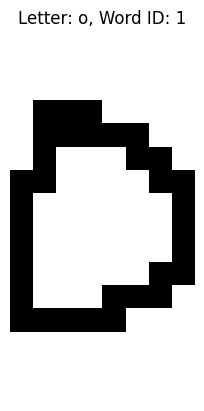

In [101]:
# Visualize one character as an image
def show_letter(index):
    letter_row = ocr_df.iloc[index]
    pixels = np.array(letter_row[pixel_cols], dtype=np.float32).reshape(16, 8)
    plt.imshow(pixels, cmap='Greys')
    plt.title(f"Letter: {letter_row['letter']}, Word ID: {letter_row['word_id']}")
    plt.axis('off')
    plt.show()

# Show the first character
show_letter(0)

### Group Letters Into Words Using word_id

In [102]:
# Extract only the pixel columns
pixel_cols = [col for col in ocr_df.columns if col.startswith('p_')]

# Store sequences
word_sequences = []

# Group by word_id
for word_id, group in ocr_df.groupby('word_id'):
    group = group.sort_values('position')                # Sort characters in the correct order
    X_seq = group[pixel_cols].values.astype(np.float32)  # Get input features (each row is a character's pixels)
    Y_seq = group['letter'].tolist()                     # Get label sequence (each character label)
    word_sequences.append((X_seq, Y_seq))                # Append tuple (X_seq, y_seq)

In [103]:
# View first word
x0, y0 = word_sequences[0]
print("Shape of input:", x0.shape)
print("Labels:", y0)

Shape of input: (9, 128)
Labels: ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g']


In [104]:
# Making sure the character sequence actually starts with an "o"
# View the first word_id 
first_word_id = ocr_df['word_id'].unique()[0]

# Check all letters for that word
ocr_df[ocr_df['word_id'] == first_word_id].sort_values('position')[['letter', 'position']]

,letter,position
0,o,1
1,m,2
2,m,3
3,a,4
4,n,5
5,d,6
6,i,7
7,n,8
8,g,9


### Implement Sliding Window Feature Extraction

In [105]:
def apply_sliding_window(word_sequences, window_radius=1):
    """
    Creates input vectors that include context by using a sliding window over each character.
 
    Args:
        word_sequences: list of (X_seq, y_seq) tuples
        - X_seq is a 2D array of shape (L, 128) where L is word length
        - y_seq is a 1D array of length L (L,) (labels for each character)
        window_radius: number of characters before and after the center character
    
    Returns:
        X_all: list of np.arrays of shape (L, (2*window_radius + 1) * 128)
        y_all: list of label sequences (list of chars)
    """
    X_all = []
    Y_all = []

    # Loop through each word
    for X_seq, Y_seq in word_sequences:
        L = X_seq.shape[0]
        pad = np.zeros((window_radius, X_seq.shape[1]), dtype=np.float32)    # Create padding of zeros to add on both sides of the sequence
        
        # Pad the original sequence on both ends to avoid index issues
        X_padded = np.vstack([pad, X_seq, pad])
        X_windowed = []

        # Build window around each character in the word
        for i in range(window_radius, L + window_radius):
            window = X_padded[i - window_radius: i + window_radius + 1]    # Get window of features around the current character
            X_windowed.append(window.flatten())                            # Flatten window into a single feature vector

        # Add the windowed input and labels
        X_all.append(np.array(X_windowed))  # Shape: (L, (2r+1)*128)
        Y_all.append(Y_seq)
    
    return X_all, Y_all

In [106]:
# Create windowed features with 1 character of context on each side
X_windowed, Y_windowed = apply_sliding_window(word_sequences, window_radius=1)

# View shape of one word
print("Windowed shape:", X_windowed[0].shape)  # Should be (word_len, 128 * 3)
print("Labels:", Y_windowed[0])

Windowed shape: (9, 384)
Labels: ['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g']


### Split the Data Into Train/Test Sets (1,000/4,000, 2,500/2,500, and 4,000/1,000)

In [107]:
def create_dataset_splits(X, Y, sizes=[(1000, 4000), (2500, 2500), (4000, 1000)], seed=42):
    """
    Create multiple train/test splits with specific (train_size, test_size) combinations.
    
    Args:
        X: list of input sequences (e.g., word-level feature vectors)
        y: list of output sequences (e.g., word-level letter labels)
        sizes: list of (train_size, test_size) tuples
        seed: random seed to make sure splits are reproducible
    
    Returns:
        List of (X_train, X_test, y_train, y_test) tuples
    """
    all_splits = []

    # Go through each (train, test) split 
    for train_size, test_size in sizes:
        X_train, X_test, Y_train, Y_test = train_test_split(                    # Using sklearn split the data randomly but consistently with the seed
            X, Y, train_size=train_size, test_size=test_size, random_state=seed 
        )
        # Save the split so we can loop through later
        all_splits.append((X_train, X_test, Y_train, Y_test))
    
    return all_splits

In [108]:
# Create windowed datasets and splits for each radius (0 = no context, 3 = wider context)
window_radii = [0, 1, 2, 3]
all_windowed_splits = {}

# Loop through each window radius
for r in window_radii:
    X_windowed, Y_windowed = apply_sliding_window(word_sequences, window_radius=r)   # Add context around each character using a sliding window
    splits = create_dataset_splits(X_windowed, Y_windowed)                           # Create 3 different splits (eg., 1,000/ 4,000, etc.)
    all_windowed_splits[r] = splits                                                  # Save the splits for this radius

## Implement the Conditional Random Fields (CRF) Model Using sklearn-crfsuite

In [109]:
!pip install sklearn-crfsuite

### Convert Features to CRF Format

In [110]:
def vector_to_features(vec, index):
    """
    Converts a single feature vector into a feature dictionary for the CRF model.
    Index is used to name features uniquely.
    """
    return {f'f{index}_{i}': val for i, val in enumerate(vec)}

In [111]:
# Format the data for CRFs
def convert_for_crf(X_seq_list, Y_seq_list):
    X_crf = []     # Store the input feature dicts for each word
    Y_crf = []     # Store the corresponding label sequences

    # Loop through each word's input and label sequence
    for X_seq, Y_seq in zip(X_seq_list, Y_seq_list):
        features = [vector_to_features(x, i) for i, x in enumerate(X_seq)]    # Convert each character's feature vector into a dictionary
        X_crf.append(features)    # Add the feature dicts for this word
        Y_crf.append(Y_seq)       # Add the label sequence for this word
        
    return X_crf, Y_crf

### Train the CRF Model and Loop Over Splits and Window Sizes

In [112]:
# Store all results
results = []

# Loop through each window size
for radius, splits in all_windowed_splits.items():
    # For each window size, loop through the 3 train/test splits (eg., 1,000/ 4,000, etc.)
    for split_index, (X_train, X_test, Y_train, Y_test) in enumerate(splits):
        # View current setup so we know what we’re training on
        print(f"[CRF] Window radius: {radius}, Split {split_index + 1}")

        # Convert to CRF feature format
        X_crf_train, Y_crf_train = convert_for_crf(X_train, Y_train)
        X_crf_test, Y_crf_test = convert_for_crf(X_test, Y_test)

        # Initialize and train CRF model
        crf = sklearn_crfsuite.CRF(algorithm='lbfgs', max_iterations=100)
        t0 = time.time()
        crf.fit(X_crf_train, Y_crf_train)
        train_time = time.time() - t0

        # Predict labels for the test set
        t0 = time.time()
        Y_pred = crf.predict(X_crf_test)
        test_time = time.time() - t0

        # Flatten both true and predicted label sequences into a single list
        flat_true = [label for seq in Y_crf_test for label in seq]
        flat_pred = [label for seq in Y_pred for label in seq]

        # Calculate overall accuracy score
        accuracy = metrics.flat_accuracy_score(flat_true, flat_pred)

        # Save results for this radius and split to compare later
        results.append({
            'Radius': radius,
            'Split': split_index + 1,
            'Train Size': len(X_train),
            'Test Size': len(X_test),
            'Accuracy': accuracy,
            'Train Time (s)': train_time,
            'Test Time (s)': test_time
        })

        # Summary of results
        print(f" Accuracy: {accuracy:.4f} | Train: {train_time:.2f}s | Test: {test_time:.2f}s")

[CRF] Window radius: 0, Split 1
 Accuracy: 0.7728 | Train: 2.72s | Test: 0.61s
[CRF] Window radius: 0, Split 2
 Accuracy: 0.8274 | Train: 8.87s | Test: 0.38s
[CRF] Window radius: 0, Split 3
 Accuracy: 0.8534 | Train: 15.67s | Test: 0.15s
[CRF] Window radius: 1, Split 1
 Accuracy: 0.8397 | Train: 8.75s | Test: 1.66s
[CRF] Window radius: 1, Split 2
 Accuracy: 0.8877 | Train: 27.95s | Test: 1.01s
[CRF] Window radius: 1, Split 3
 Accuracy: 0.9015 | Train: 45.21s | Test: 0.43s
[CRF] Window radius: 2, Split 1
 Accuracy: 0.8936 | Train: 15.17s | Test: 3.53s
[CRF] Window radius: 2, Split 2
 Accuracy: 0.9328 | Train: 47.44s | Test: 2.32s
[CRF] Window radius: 2, Split 3
 Accuracy: 0.9476 | Train: 74.49s | Test: 0.94s
[CRF] Window radius: 3, Split 1
 Accuracy: 0.9196 | Train: 21.81s | Test: 7.25s
[CRF] Window radius: 3, Split 2
 Accuracy: 0.9516 | Train: 75.11s | Test: 8.54s
[CRF] Window radius: 3, Split 3
 Accuracy: 0.9630 | Train: 118.66s | Test: 3.76s


### Save the Results as a Table

In [113]:
crf_results_df = pd.DataFrame(results)
crf_results_df

,Radius,Split,Train Size,Test Size,Accuracy,Train Time (s),Test Time (s)
0,0,1,1000,4000,0.772829,2.718131,0.609275
1,0,2,2500,2500,0.827363,8.869047,0.378494
2,0,3,4000,1000,0.853420,15.669496,0.148246
3,1,1,1000,4000,0.839737,8.745572,1.657535
4,1,2,2500,2500,0.887697,27.951567,1.009984
5,1,3,4000,1000,0.901498,45.208085,0.434294
6,2,1,1000,4000,0.893553,15.171922,3.526941
7,2,2,2500,2500,0.932828,47.437902,2.316230
8,2,3,4000,1000,0.947622,74.486019,0.936873
9,3,1,1000,4000,0.919638,21.813320,7.249519


## Auto-Context Implementation Using CRF Model

### Incorporating Predicted Labels as Features

In [114]:
def augment_with_predictions(X_seq_list, Y_pred_list):
    """
    Add predicted labels as features to each character's feature vector.
    Return a new list of augmented sequences.
    """
    augmented_X = []
    
    # Loop through each sequence and its corresponding predicted labels
    for X_seq, Y_pred in zip(X_seq_list, Y_pred_list):
        augmented_seq = []

        # Loop through each character's features and its predicted label
        for x, pred in zip(X_seq, Y_pred):
            pred_feature = [ord(pred) - ord('a')]                      # Turn the predicted letter into a number (e.g., 'a' = 0, 'b' = 1, etc.)
            augmented_seq.append(np.concatenate([x, pred_feature]))    # Add the prediction as a new feature to the original vector 
        augmented_X.append(augmented_seq)                              # Store the augmented sequence
    return augmented_X

### Train the Auto-Context CRF Model and Loop Over Splits and Window Sizes

In [115]:
# Store all results
auto_results = []

# Loop through each window size
for radius, splits in all_windowed_splits.items():
    # For each window size, loop through the 3 train/test splits (e.g., 1,000/4,000, etc.)
    for split_index, (X_train, X_test, Y_train, Y_test) in enumerate(splits):
        # View current setup so we know what we’re training on
        print(f"[Auto-context] Window radius: {radius}, Split: {split_index + 1}")

        # First CRF Pass 
        # Convert to CRF feature format
        X_crf_train, Y_crf_train = convert_for_crf(X_train, Y_train)
        X_crf_test, Y_crf_test = convert_for_crf(X_test, Y_test)

        # Train the first CRF model
        crf1 = sklearn_crfsuite.CRF(algorithm='lbfgs', max_iterations=100)
        crf1.fit(X_crf_train, Y_crf_train)

        # Predict labels from the first CRF
        Y_pred_train = crf1.predict(X_crf_train)
        Y_pred_test = crf1.predict(X_crf_test)

        # Augment original features with predicted labels from the first CRF
        X_train_aug = augment_with_predictions(X_train, Y_pred_train)
        X_test_aug = augment_with_predictions(X_test, Y_pred_test)

        # Second CRF Pass (Auto-Context CRF)
        # Convert augmented inputs to CRF format
        X_crf_train_aug, Y_crf_train = convert_for_crf(X_train_aug, Y_train)
        X_crf_test_aug, Y_crf_test = convert_for_crf(X_test_aug, Y_test)

        # Train the second CRF with augmented features
        crf2 = sklearn_crfsuite.CRF(algorithm='lbfgs', max_iterations=100)
        t0 = time.time()
        crf2.fit(X_crf_train_aug, Y_crf_train)
        train_time = time.time() - t0

        # Predict labels using the second CRF
        t0 = time.time()
        Y_pred_final = crf2.predict(X_crf_test_aug)
        test_time = time.time() - t0

        # Flatten both true and predicted label sequences into a single list
        flat_true = [label for seq in Y_crf_test for label in seq]
        flat_pred = [label for seq in Y_pred_final for label in seq]
        accuracy = metrics.flat_accuracy_score(flat_true, flat_pred)

        # Save results for this radius and split to compare later
        auto_results.append({
            'Radius': radius,
            'Split': split_index + 1,
            'Train Size': len(X_train),
            'Test Size': len(X_test),
            'Accuracy': accuracy,
            'Train Time (s)': train_time,
            'Test Time (s)': test_time
        })

         # Summary of results
        print(f" Accuracy: {accuracy:.4f} | Train: {train_time:.2f}s | Test: {test_time:.2f}s")

[Auto-context] Window radius: 0, Split: 1
 Accuracy: 0.7756 | Train: 3.60s | Test: 0.57s
[Auto-context] Window radius: 0, Split: 2
 Accuracy: 0.8289 | Train: 8.79s | Test: 0.33s
[Auto-context] Window radius: 0, Split: 3
 Accuracy: 0.8546 | Train: 14.03s | Test: 0.15s
[Auto-context] Window radius: 1, Split: 1
 Accuracy: 0.8400 | Train: 10.91s | Test: 1.55s
[Auto-context] Window radius: 1, Split: 2
 Accuracy: 0.8883 | Train: 27.61s | Test: 1.05s
[Auto-context] Window radius: 1, Split: 3
 Accuracy: 0.9018 | Train: 45.00s | Test: 0.41s
[Auto-context] Window radius: 2, Split: 1
 Accuracy: 0.8943 | Train: 19.50s | Test: 3.21s
[Auto-context] Window radius: 2, Split: 2
 Accuracy: 0.9338 | Train: 43.47s | Test: 1.75s
[Auto-context] Window radius: 2, Split: 3
 Accuracy: 0.9481 | Train: 65.02s | Test: 0.72s
[Auto-context] Window radius: 3, Split: 1
 Accuracy: 0.9196 | Train: 22.60s | Test: 7.14s
[Auto-context] Window radius: 3, Split: 2
 Accuracy: 0.9527 | Train: 73.08s | Test: 16.49s
[Auto-conte

### Save the Results as a Table

In [89]:
auto_results_df = pd.DataFrame(auto_results)
auto_results_df

,Radius,Split,Train Size,Test Size,Accuracy,Train Time (s),Test Time (s)
0,0,1,1000,4000,0.775592,3.107261,0.468102
1,0,2,2500,2500,0.828889,7.740359,0.297006
2,0,3,4000,1000,0.854593,13.252162,0.141485
3,1,1,1000,4000,0.840033,9.752910,1.356762
4,1,2,2500,2500,0.888275,22.205780,0.825494
5,1,3,4000,1000,0.901759,37.875535,0.364561
6,2,1,1000,4000,0.894342,14.815534,2.444131
7,2,2,2500,2500,0.933828,39.052459,1.760078
8,2,3,4000,1000,0.948143,63.914219,0.690830
9,3,1,1000,4000,0.919605,23.389418,6.686745


### Verify Feature Augmentation in Auto-Context CRF Model

In [90]:
print("Original shape:", X_train[0][0].shape)       # should be (896,)
print("Augmented shape:", X_train_aug[0][0].shape)  # should be (897,)

Original shape: (896,)
Augmented shape: (897,)


## Comparison of CRF and Auto-Context CRF Models

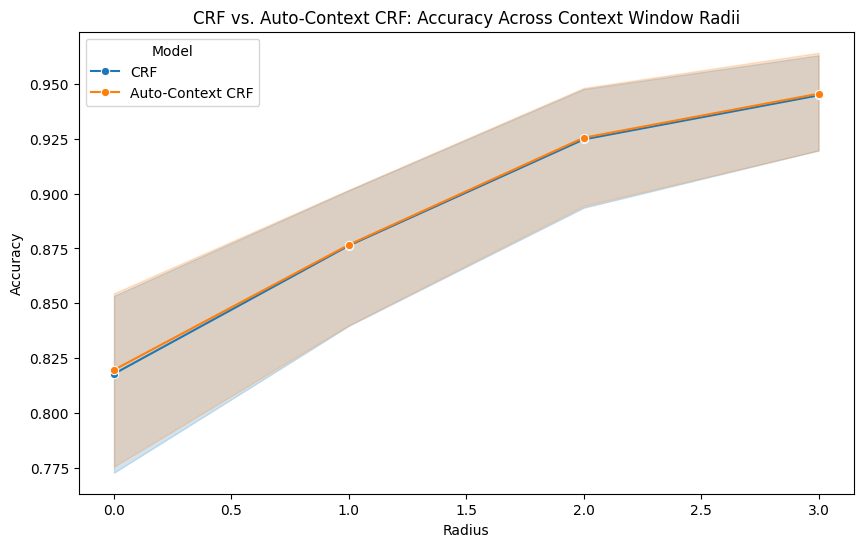

In [91]:
# Merge CRF and Auto-Context CRF results for comparison
crf_results_df['Model'] = 'CRF'
auto_results_df['Model'] = 'Auto-Context CRF'
comparison_df = pd.concat([crf_results_df, auto_results_df], ignore_index=True)

# Compare accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x='Radius', y='Accuracy', hue='Model', marker='o')
plt.title("CRF vs. Auto-Context CRF: Accuracy Across Context Window Radii")
plt.show()